In [ ]:
# 라이브러리
import numpy as np
import pandas as pd
from PIL import Image
import os 
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from contextlib import nullcontext
import matplotlib.pyplot as plt

In [9]:
# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = torch.cuda.is_available()

In [10]:
# 데이터셋 정의
# Dataset for images
class ImageDataset(Dataset):
    def __init__(self, folder, start_date='1978-11', end_date='2025-04', indices=None):
        self.folder = folder
        self.dates = pd.date_range(start=start_date, end=end_date, freq='MS')
        self.indices = indices if indices is not None else range(len(self.dates) - 60)
        self.transform = T.ToTensor()  # [0, 255] -> [0, 1]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        idx = self.indices[i]
        imgs = []
        for j in range(60):
            date = self.dates[idx + j]
            path = os.path.join(self.folder, f"image_grey/256x256/img_grey_{date.year}{date.month:02d}.png")
            img = self.transform(Image.open(path))
            imgs.append(img)
        x = torch.cat(imgs, dim=0)  # (60, 256, 256)

        date = self.dates[idx + 60]
        path = os.path.join(self.folder, f"image_grey/256x256/img_grey_{date.year}{date.month:02d}.png")
        y = self.transform(Image.open(path))  # (1, 256, 256)

        return x, y

In [11]:
# Generator of GAN
class Generator(nn.Module):
    def __init__(self, in_channels=60, out_channels=1, features=64):
        super().__init__()

        def block_down(in_channels, out_channels, first=False):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if not first:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        def block_up(in_channels, out_channels, last=False):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if not last:
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU())
            else:
                layers.append(nn.Sigmoid())
            return nn.Sequential(*layers)

        self.down_1 = block_down(in_channels, features, first=True)
        self.down_2 = block_down(features, features * 2)
        self.down_3 = block_down(features * 2, features * 4)
        self.down_4 = block_down(features * 4, features * 8)
        self.down_5 = block_down(features * 8, features * 8)
        self.down_6 = block_down(features * 8, features * 8)

        self.up_1 = block_up(features * 8, features * 8)
        self.up_2 = block_up(features * 8 * 2, features * 8)
        self.up_3 = block_up(features * 8 * 2, features * 4)
        self.up_4 = block_up(features * 4 * 2, features * 2)
        self.up_5 = block_up(features * 2 * 2, features)
        self.up_6 = block_up(features * 2, out_channels, last=True)

    def forward(self, x):
        d1 = self.down_1(x)
        d2 = self.down_2(d1)
        d3 = self.down_3(d2)
        d4 = self.down_4(d3)
        d5 = self.down_5(d4)
        d6 = self.down_6(d5)

        u1 = self.up_1(d6)
        u2 = self.up_2(torch.cat([u1, d5], dim=1))
        u3 = self.up_3(torch.cat([u2, d4], dim=1))
        u4 = self.up_4(torch.cat([u3, d3], dim=1))
        u5 = self.up_5(torch.cat([u4, d2], dim=1))
        u6 = self.up_6(torch.cat([u5, d1], dim=1))

        return u6

In [12]:
# Discriminator of GAN
class Discriminator(nn.Module):
    def __init__(self, in_channels=61, features=64):
        super().__init__()

        def block(in_channels, out_channels, normalize=True, last=False):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=1 if last else 2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            block(in_channels, features, normalize=False),
            block(features, features * 2),
            block(features * 2, features * 4),
            block(features * 4, features * 8),
            block(features * 8, 1, normalize=False, last=True)
        )

    def forward(self, x, y):
        return self.model(torch.cat([x, y], dim=1))

In [13]:
# Paths and dataset
DIR_PATH = "C:/Users/qkrwn/OneDrive/Desktop/JH/AI/Project002/datas"
data_path = os.path.join(DIR_PATH, "image_grey/256x256")
dataset_full = ImageDataset(data_path)
n = len(dataset_full)

idx_train = list(range(0, int(n * 0.6)))
idx_val = list(range(int(n * 0.6), int(n * 0.8)))
idx_test = list(range(int(n * 0.8), n))

ds_train = ImageDataset(DIR_PATH, indices=idx_train)
ds_val = ImageDataset(DIR_PATH, indices=idx_val)
ds_test = ImageDataset(DIR_PATH, indices=idx_test)

dl_train = DataLoader(ds_train, batch_size=2, shuffle=True, pin_memory=True, num_workers=0)
dl_val = DataLoader(ds_val, batch_size=2, shuffle=False, pin_memory=True, num_workers=0)
dl_test = DataLoader(ds_test, batch_size=1, shuffle=False, pin_memory=True, num_workers=0)

In [16]:
# Model
gen = Generator().to(device)
dis = Discriminator().to(device)

# Optimizer & Scaler
optimizer_gen = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_dis = torch.optim.Adam(dis.parameters(), lr=1e-4, betas=(0.5, 0.999))
scaler_gen = GradScaler(enabled=use_amp)
scaler_dis = GradScaler(enabled=use_amp)

# Loss
loss_fn_adv = nn.BCEWithLogitsLoss()
loss_fn_rec = nn.L1Loss()

C:\Users\qkrwn\AppData\Local\Temp\ipykernel_29704\1091889425.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_gen = GradScaler(enabled=use_amp)
C:\Users\qkrwn\AppData\Local\Temp\ipykernel_29704\1091889425.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_dis = GradScaler(enabled=use_amp)


In [17]:
# Training
epochs = 100
for epoch in range(epochs):
    gen.train()
    dis.train()
    loop = tqdm(dl_train, desc=f"Epoch {epoch + 1}/{epochs}")

    for x, y in loop:
        x, y = x.to(device), y.to(device)

        with autocast() if use_amp else nullcontext():
            y_fake = gen(x)
            pred_real = dis(x, y)
            pred_fake = dis(x, y_fake.detach())
            loss_dis = loss_fn_adv(pred_real, torch.ones_like(pred_real)) + \
                       loss_fn_adv(pred_fake, torch.zeros_like(pred_fake))

        optimizer_dis.zero_grad()
        scaler_dis.scale(loss_dis).backward()
        scaler_dis.step(optimizer_dis)
        scaler_dis.update()

        with autocast() if use_amp else nullcontext():
            pred_fake = dis(x, y_fake)
            loss_gen = loss_fn_adv(pred_fake, torch.ones_like(pred_fake)) + \
                       100 * loss_fn_rec(y, y_fake)

        optimizer_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(optimizer_gen)
        scaler_gen.update()

        loop.set_postfix(loss_g=loss_gen.item(), loss_d=loss_dis.item())

Epoch 1/100:   0%|          | 0/149 [00:00<?, ?it/s]C:\Users\qkrwn\AppData\Local\Temp\ipykernel_29704\1751167902.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast() if use_amp else nullcontext():
C:\Users\qkrwn\AppData\Local\Temp\ipykernel_29704\1751167902.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast() if use_amp else nullcontext():
Epoch 100/100: 100%|██████████| 149/149 [00:15<00:00,  9.58it/s, loss_d=1.39, loss_g=1.37]


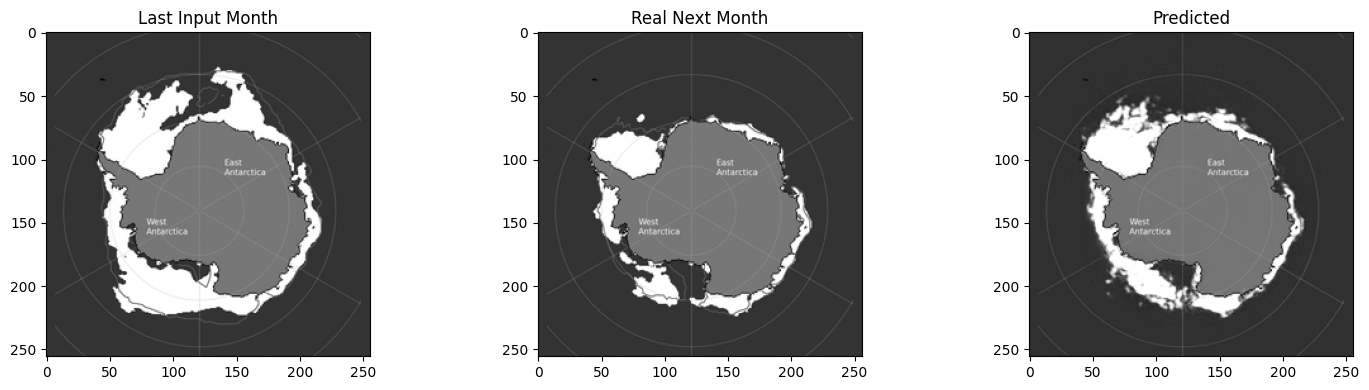

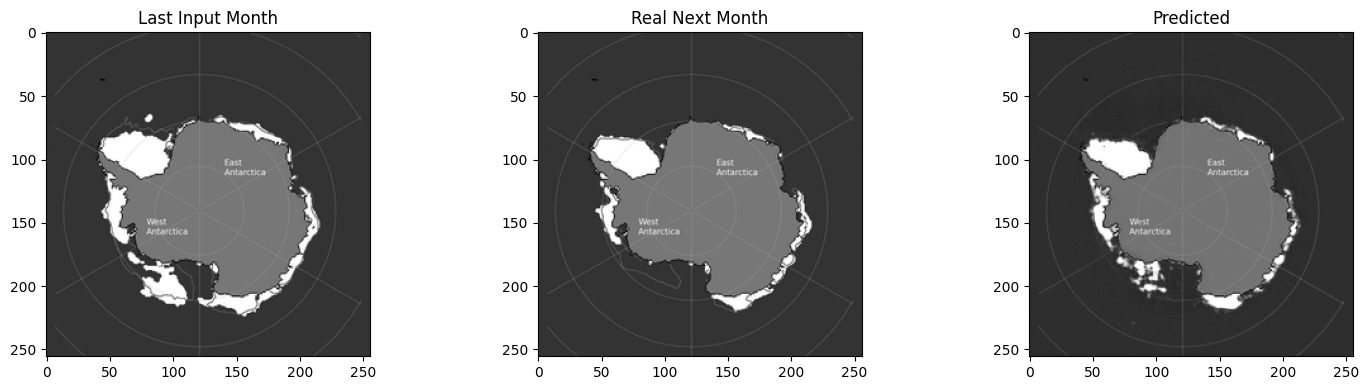

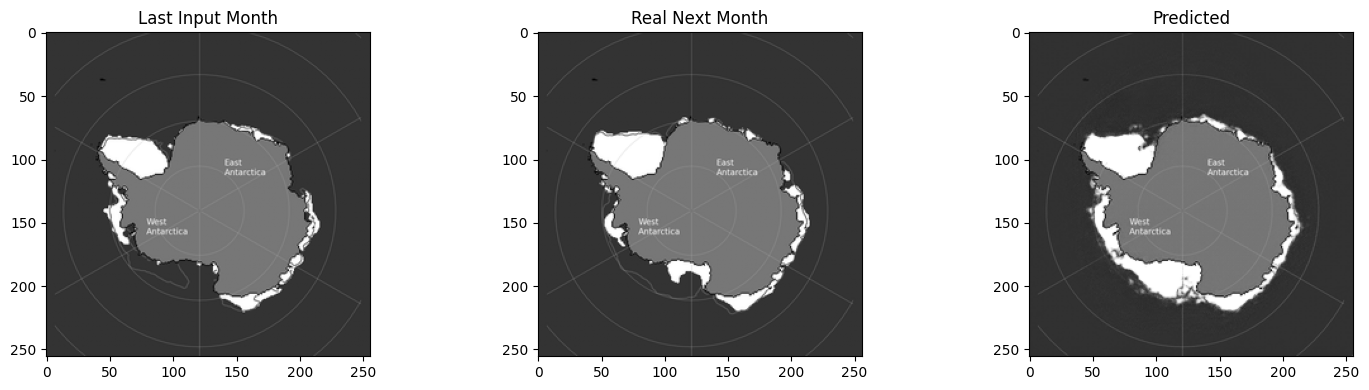

In [18]:
# 테스트 후 시각화
gen.eval()
with torch.inference_mode():
    for i, (x, y_true) in enumerate(dl_test):
        x, y_true = x.to(device), y_true.to(device)
        y_pred = gen(x)

        plt.figure(figsize=(15, 4))

        # 입력의 마지막 달
        plt.subplot(1, 3, 1)
        plt.title("Last Input Month")
        plt.imshow(x[0][-1].cpu(), cmap='gray')

        # 정답
        plt.subplot(1, 3, 2)
        plt.title("Real Next Month")
        plt.imshow(y_true[0][0].cpu(), cmap='gray')

        # 예측
        plt.subplot(1, 3, 3)
        plt.title("Predicted")
        plt.imshow(y_pred[0][0].cpu(), cmap='gray')

        plt.tight_layout()
        plt.show()

        if i == 2:
            break


In [ ]:
from torchvision.utils import save_image

# 이후 2년치 이미지 저장
gen.eval()
os.makedirs(f"{DIR_PATH}/predict/image_autoregressive2", exist_ok=True)
img_path = os.path.join(DIR_PATH, "predict/image_autoregressive2")

x_test, _ = next(iter(dl_test))
x_curr = x_test[0].unsqueeze(0).to(device)  # (1, 60, 256, 256)

with torch.inference_mode():
    for step in range(24):
        y_pred = gen(x_curr)  # 예측값 생성
        print(f"Step {step} - raw y_pred shape: {y_pred.shape}")

        # 차원 정리
        y_pred = y_pred.squeeze()  # (256, 256)
        y_pred = y_pred.unsqueeze(0).unsqueeze(0)  # (1, 1, 256, 256)

        # 이미지 저장
        save_image(y_pred[0], f"{img_path}/pred_{step:02d}.png")

        # 입력 시퀀스 업데이트
        x_curr = torch.cat([x_curr[:, 1:], y_pred], dim=1)  # 슬라이딩 윈도우

        print(f"Step {step} - x_curr updated shape: {x_curr.shape}")

Step 0 - raw y_pred shape: torch.Size([1, 1, 256, 256])
Step 0 - x_curr updated shape: torch.Size([1, 60, 256, 256])
Step 1 - raw y_pred shape: torch.Size([1, 1, 256, 256])
Step 1 - x_curr updated shape: torch.Size([1, 60, 256, 256])
Step 2 - raw y_pred shape: torch.Size([1, 1, 256, 256])
Step 2 - x_curr updated shape: torch.Size([1, 60, 256, 256])
Step 3 - raw y_pred shape: torch.Size([1, 1, 256, 256])
Step 3 - x_curr updated shape: torch.Size([1, 60, 256, 256])
Step 4 - raw y_pred shape: torch.Size([1, 1, 256, 256])
Step 4 - x_curr updated shape: torch.Size([1, 60, 256, 256])
Step 5 - raw y_pred shape: torch.Size([1, 1, 256, 256])
Step 5 - x_curr updated shape: torch.Size([1, 60, 256, 256])
Step 6 - raw y_pred shape: torch.Size([1, 1, 256, 256])
Step 6 - x_curr updated shape: torch.Size([1, 60, 256, 256])
Step 7 - raw y_pred shape: torch.Size([1, 1, 256, 256])
Step 7 - x_curr updated shape: torch.Size([1, 60, 256, 256])
Step 8 - raw y_pred shape: torch.Size([1, 1, 256, 256])
Step 8 -